## Combining and Loading Dataset

In [1]:
# Import warnings to avoid error
import warnings
warnings.filterwarnings("ignore")

# Import Hugging Face dataset loader
from datasets import load_dataset
# Import pandas for data manipulation
import pandas as pd

# Load the emotion dataset (train, validation, test splits)
dataset = load_dataset("dair-ai/emotion")

# Convert training split to DataFrame
train_df = pd.DataFrame(dataset["train"])

# Convert validation split to DataFrame
validation_df = pd.DataFrame(dataset["validation"])

# Convert test split to DataFrame
test_df = pd.DataFrame(dataset["test"])

# Concatenate train, validation, and test datasets
# ignore_index=True resets row indexing
full_df = pd.concat(
    [train_df, validation_df, test_df],
    ignore_index=True
)

# Display the shape of the combined dataset
print("Combined dataset shape:", full_df.shape)


Combined dataset shape: (20000, 2)


## Saving dataset to local directory

In [2]:
# Save the combined dataset into a CSV file
# The file will be saved in the same directory as this notebook
full_df.to_csv("emotion_full_dataset.csv", index=False)

print("Dataset saved as emotion_full_dataset.csv to working directory")



Dataset saved as emotion_full_dataset.csv to working directory


In [3]:
# Load the locally saved CSV file for further analysis
df = pd.read_csv("emotion_full_dataset.csv")

# Display first few rows
df.head()



,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


# Exploratory Data Analysis (EDA)

## 1) Dataset Overview

In [4]:
# Display dataset structure and data types
df.info()

# Display descriptive statistics for all columns
df.describe(include="all")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20000 non-null  object
 1   label   20000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


,text,label
count,20000,20000.000000
unique,19948,NaN
top,i will feel as though i am accepted by as well...,NaN
freq,2,NaN
mean,NaN,1.562850
std,NaN,1.496684
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,1.000000
75%,NaN,3.000000


In [5]:
# Create a dictionary to map label numbers to emotion names
emotion_map = {
    0: "Sadness",
    1: "Joy",
    2: "Love",
    3: "Anger",
    4: "Fear",
    5: "Surprise"
}

# Create a new column with emotion names
df["emotion"] = df["label"].map(emotion_map)


## 2) Distribution of Emotion Classes

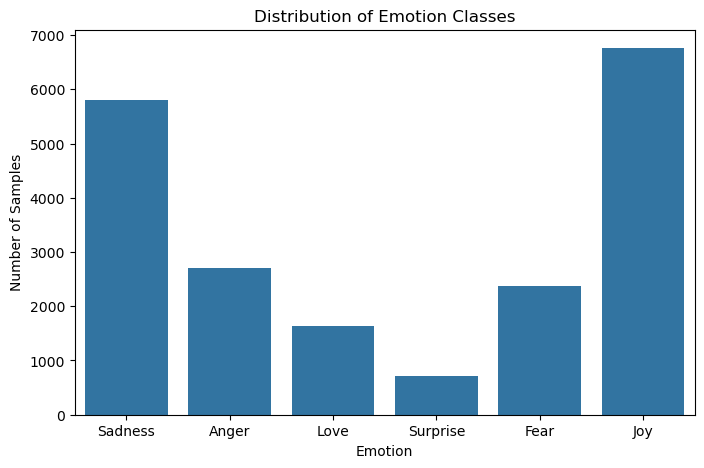

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot class distribution to check balance among emotion categories
plt.figure(figsize=(8,5))
sns.countplot(x="emotion", data=df)
plt.title("Distribution of Emotion Classes")
plt.xlabel("Emotion")
plt.ylabel("Number of Samples")
plt.show()


## 3) Distribution of Text Lengths

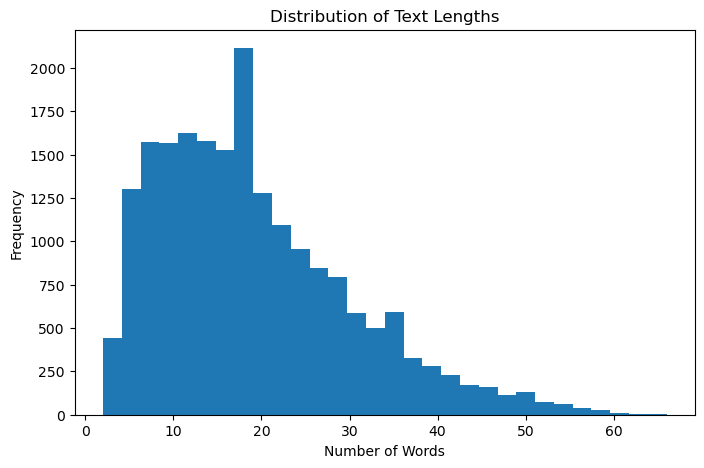

In [7]:
# Calculate the number of words in each text sample
df["text_length"] = df["text"].apply(lambda x: len(x.split()))

# Plot histogram of text lengths
plt.figure(figsize=(8,5))
plt.hist(df["text_length"], bins=30)
plt.title("Distribution of Text Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


## 4) Text Length Distribution by Emotion

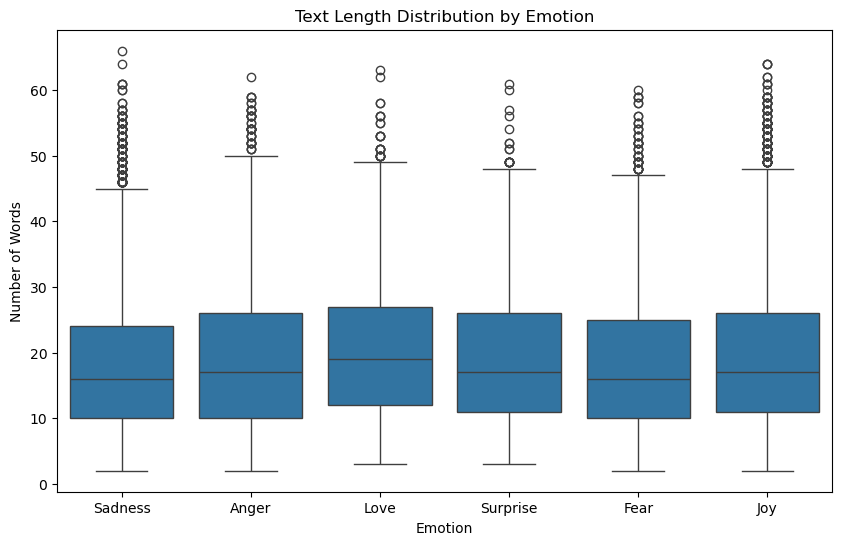

In [8]:
# Compare text length across different emotions
plt.figure(figsize=(10,6))
sns.boxplot(x="emotion", y="text_length", data=df)
plt.title("Text Length Distribution by Emotion")
plt.xlabel("Emotion")
plt.ylabel("Number of Words")
plt.show()


## 5) Top 20 Most Frequent Words in Dataset

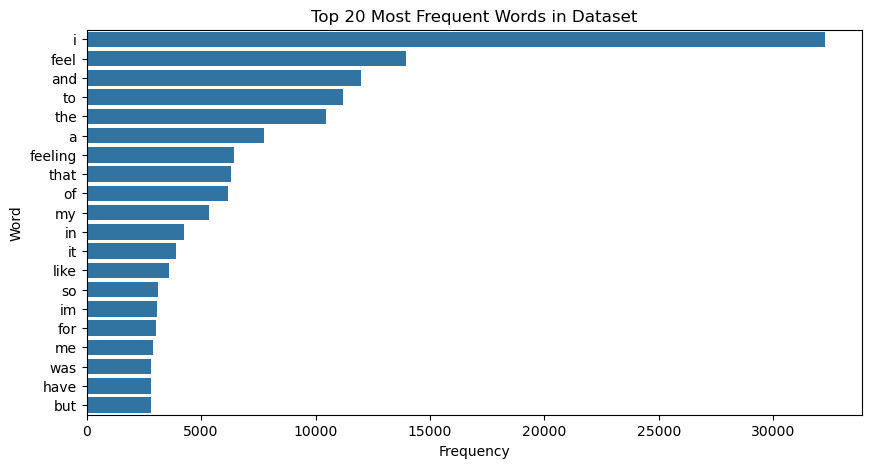

In [9]:
from collections import Counter
import re

# Collect all words from the dataset
words = []
for text in df["text"]:
    # Convert text to lowercase and extract words
    tokens = re.findall(r"\b\w+\b", text.lower())
    words.extend(tokens)

# Get the 20 most common words
common_words = Counter(words).most_common(20)

# Convert to DataFrame for visualization
word_df = pd.DataFrame(common_words, columns=["Word", "Frequency"])

# Plot frequent words
plt.figure(figsize=(10,5))
sns.barplot(x="Frequency", y="Word", data=word_df)
plt.title("Top 20 Most Frequent Words in Dataset")
plt.show()


## 6) Frequently Occuring Words in Emotion Dataset Wordcloud

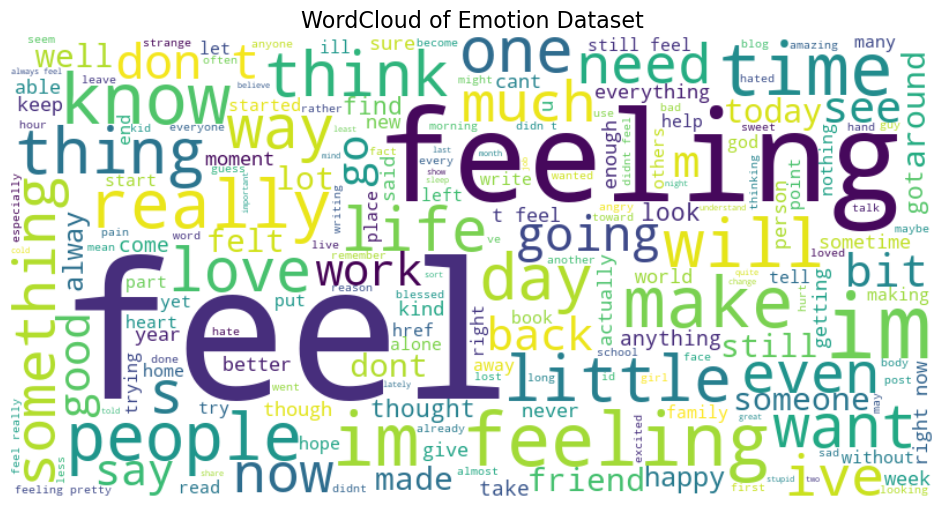

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all text
all_text = " ".join(df["text"].astype(str))

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    max_words=200
).generate(all_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud of Emotion Dataset", fontsize=16)
plt.show()

## 7) Emotion Wise Wordcloud 

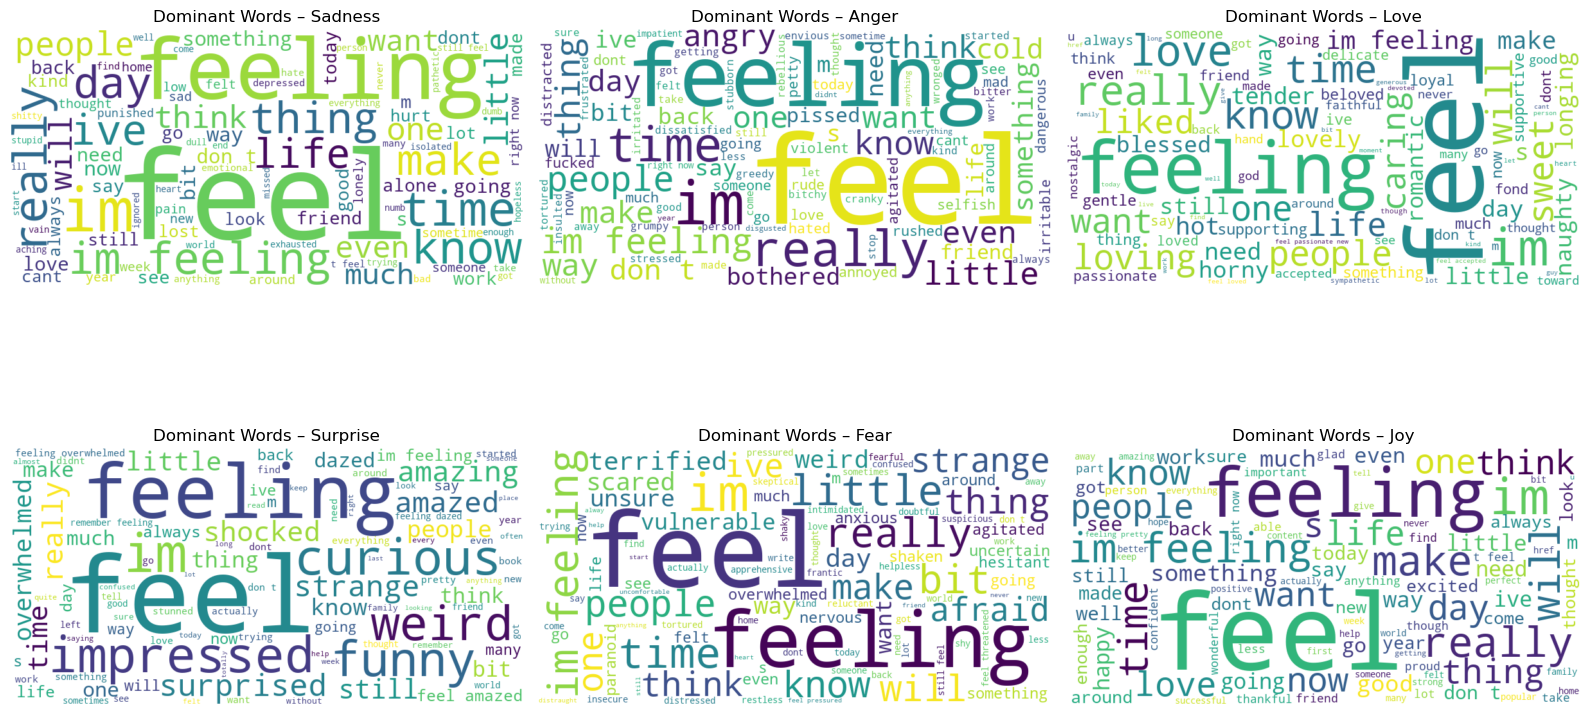

In [11]:
# Get all unique emotion labels from the dataset
emotions = df['emotion'].unique()

# Create a large figure to display multiple WordClouds
plt.figure(figsize=(16, 10))

# Loop through each emotion and generate its WordCloud
for i, emotion in enumerate(emotions, 1):
    
    # Combine all text samples belonging to the current emotion into one string
    emotion_text = " ".join(df[df['emotion'] == emotion]['text'])
    
    # Create a WordCloud for the current emotion
    wc = WordCloud(
        width=800,                # Width of the WordCloud image
        height=400,               # Height of the WordCloud image
        background_color='white', # White background for clarity
        max_words=100,             # Limit to top 100 most frequent words
        colormap='viridis'         # Color scheme for visual distinction
    ).generate(emotion_text)
    
    # Place the WordCloud in a subplot grid
    plt.subplot(2, 3, i)          # Adjust rows/columns based on number of emotions
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')               # Remove axes for better visualization
    
    # Set title for each emotion-specific WordCloud
    plt.title(f"Dominant Words – {emotion}")

# Adjust layout to prevent overlapping of plots
plt.tight_layout()

# Display all emotion-wise WordClouds
plt.show()

# Train Test Split

In [12]:
from sklearn.model_selection import train_test_split
# Separate features (text) and target (label)
X = df["text"]
y = df["label"]

# Split dataset into training and testing sets
# stratify=y ensures class balance in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


# TF-IDF Vectorizor

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    stop_words="english",
    ngram_range=(1,2),
    max_features=10000
)

# Fit TF-IDF on training data and transform both sets
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


# 1) Naive Bayes Algorithm

## Initial Classification Report from Multinomial Naive Bayes

In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Initialize Naive Bayes classifier
nb_model_before = MultinomialNB()

# Train the model
nb_model_before.fit(X_train_tfidf, y_train)

# Predict on test data
nb_preds_before = nb_model_before.predict(X_test_tfidf)

# Display performance metrics
print("Naive Bayes Accuracy (Before Tuning):",
      accuracy_score(y_test, nb_preds_before))

print(classification_report(y_test, nb_preds_before))


Naive Bayes Accuracy (Before Tuning): 0.77475
              precision    recall  f1-score   support

           0       0.76      0.94      0.84      1159
           1       0.72      0.98      0.83      1352
           2       0.97      0.24      0.38       328
           3       0.95      0.58      0.72       542
           4       0.92      0.58      0.71       475
           5       1.00      0.09      0.17       144

    accuracy                           0.77      4000
   macro avg       0.89      0.57      0.61      4000
weighted avg       0.82      0.77      0.74      4000



## Initial Predicted Result

In [15]:
# Initial Prediction
pred = nb_model_before.predict(vectorizer.transform(["i was feeling pretty anxious all day but my first day at work was a very good day and that helped a lot"]))[0]


print("Predicted emotion:", emotion_map[pred])

Predicted emotion: Joy


## ROC Curve for Naive Bayes (Before Tuning)

In [16]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

In [17]:
# Binarize labels for ROC
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

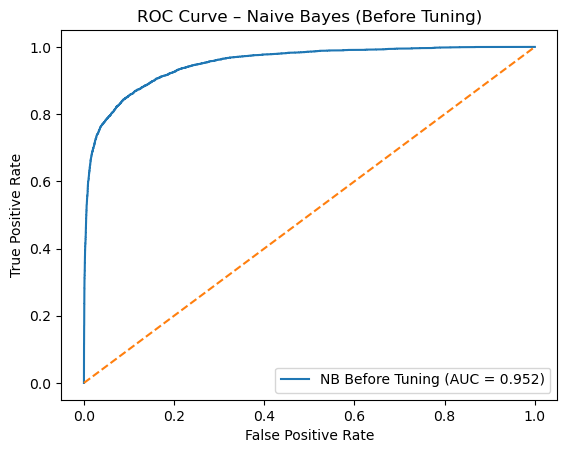

In [18]:
# Assuming you used a vectorizer during training
X_test_vec = vectorizer.transform(X_test)  # Use .transform, NOT .fit_transform

# Then predict probabilities
y_prob_nb_before = nb_model_before.predict_proba(X_test_vec)

# Assuming you binarized labels
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_prob_nb_before.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"NB Before Tuning (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Naive Bayes (Before Tuning)")
plt.legend()
plt.show()

## Confusion Matrix for Naive Bayes (Before Tuning)

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

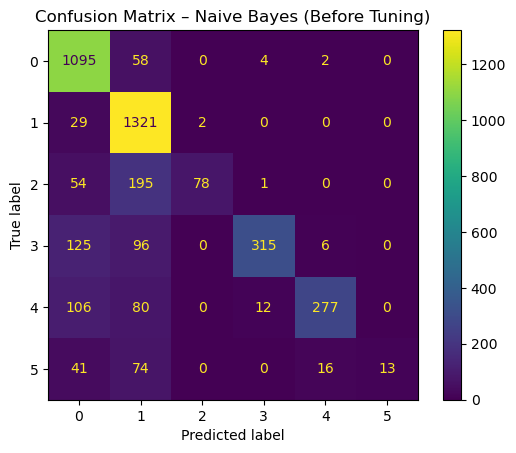

In [20]:
# Generate predictions using Naive Bayes BEFORE tuning
# nb_preds already contains predictions from the baseline model

# Compute confusion matrix
cm_nb_before = confusion_matrix(y_test, nb_preds_before)

# Create confusion matrix display
disp_nb_before = ConfusionMatrixDisplay(
    confusion_matrix=cm_nb_before,
    display_labels=classes
)

# Plot confusion matrix
disp_nb_before.plot()
plt.title("Confusion Matrix – Naive Bayes (Before Tuning)")
plt.show()

## Hyperparameter Tuning - Multinomial Naive Bayes

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

# Define hyperparameter grid for Naive Bayes
nb_param_grid = {
    "alpha": [0.1, 0.5, 1.0, 1.5, 2.0]  # Smoothing parameter
}

# Initialize GridSearchCV
nb_grid = GridSearchCV(
    MultinomialNB(),
    nb_param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

# Fit grid search on training data
nb_grid.fit(X_train_tfidf, y_train)

# Get best model
nb_model_after = nb_grid.best_estimator_

print("Best Naive Bayes alpha:", nb_grid.best_params_)


Best Naive Bayes alpha: {'alpha': 0.1}


## Classification report after hyperparameter tuning

In [22]:
from sklearn.metrics import accuracy_score, classification_report

# Predict using tuned model
nb_preds_after = nb_model_after.predict(X_test_tfidf)

# Accuracy and classification report
nb_accuracy_after = accuracy_score(y_test, nb_preds_after)

print("Naive Bayes Accuracy (After Tuning):", nb_accuracy_after)
print(classification_report(y_test, nb_preds_after))


Naive Bayes Accuracy (After Tuning): 0.84575
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      1159
           1       0.82      0.94      0.88      1352
           2       0.88      0.55      0.68       328
           3       0.91      0.79      0.84       542
           4       0.88      0.77      0.82       475
           5       0.89      0.43      0.58       144

    accuracy                           0.85      4000
   macro avg       0.87      0.74      0.78      4000
weighted avg       0.85      0.85      0.84      4000



## Predicted result after hyperparameter tuning

In [52]:
print("=" * 70)
print(" 🤖 WELCOME TO THE Naive Bayes Based EMOTION CLASSIFICATION SYSTEM 🤖")
print("=" * 70)
print("\nAvailable emotions:")
print("0: Sadness | 1: Joy | 2: Love | 3: Anger | 4: Fear | 5: Surprise")
print("=" * 70)

while True:
    print("\n🔹 Please choose an option:")
    print("1️⃣  Enter a sentence to classify emotion")
    print("❌  Type 'quit' to exit the system")

    user_text = input("\nYour input: ")

    # Exit condition
    if user_text.lower() == "quit":
        print("\n👋 Thank you for using the Emotion Classification System!")
        print("🔒 System closed successfully.")
        print("=" * 70)
        break

    # Empty input check
    if user_text.strip() == "":
        print("\n⚠️  Warning: Empty input detected.")
        print("Please enter a valid sentence.\n")
        continue

    print("\n📄 Input Text:")
    print(f"\"{user_text}\"")

    # Transform text
    user_vector = vectorizer.transform([user_text])

    # Predict emotion
    prediction = nb_model_after.predict(user_vector)[0]

    print("\n🔍 Processing...")
    print("✅ Prediction Complete!")

    print("\n🎯 Predicted Emotion:")
    print(f"➡️  {emotion_map[prediction].upper()}")

    print("\n" + "-" * 70)
    print("You can analyze another sentence or type 'quit' to exit.")
    print("-" * 70)



 🤖 WELCOME TO THE Naive Bayes Based EMOTION CLASSIFICATION SYSTEM 🤖

Available emotions:
0: Sadness | 1: Joy | 2: Love | 3: Anger | 4: Fear | 5: Surprise

🔹 Please choose an option:
1️⃣  Enter a sentence to classify emotion
❌  Type 'quit' to exit the system



Your input:  I feel sad, hopeless, and alone.



📄 Input Text:
"I feel sad, hopeless, and alone."

🔍 Processing...
✅ Prediction Complete!

🎯 Predicted Emotion:
➡️  SADNESS

----------------------------------------------------------------------
You can analyze another sentence or type 'quit' to exit.
----------------------------------------------------------------------

🔹 Please choose an option:
1️⃣  Enter a sentence to classify emotion
❌  Type 'quit' to exit the system



Your input:  I feel happy, joyful, and excited.



📄 Input Text:
"I feel happy, joyful, and excited."

🔍 Processing...
✅ Prediction Complete!

🎯 Predicted Emotion:
➡️  JOY

----------------------------------------------------------------------
You can analyze another sentence or type 'quit' to exit.
----------------------------------------------------------------------

🔹 Please choose an option:
1️⃣  Enter a sentence to classify emotion
❌  Type 'quit' to exit the system



Your input:  Iam loving you



📄 Input Text:
"Iam loving you"

🔍 Processing...
✅ Prediction Complete!

🎯 Predicted Emotion:
➡️  LOVE

----------------------------------------------------------------------
You can analyze another sentence or type 'quit' to exit.
----------------------------------------------------------------------

🔹 Please choose an option:
1️⃣  Enter a sentence to classify emotion
❌  Type 'quit' to exit the system



Your input:  I am angry, furious, and irritated.



📄 Input Text:
"I am angry, furious, and irritated."

🔍 Processing...
✅ Prediction Complete!

🎯 Predicted Emotion:
➡️  ANGER

----------------------------------------------------------------------
You can analyze another sentence or type 'quit' to exit.
----------------------------------------------------------------------

🔹 Please choose an option:
1️⃣  Enter a sentence to classify emotion
❌  Type 'quit' to exit the system



Your input:  I feel scared, afraid, and anxious.”



📄 Input Text:
"I feel scared, afraid, and anxious.”"

🔍 Processing...
✅ Prediction Complete!

🎯 Predicted Emotion:
➡️  FEAR

----------------------------------------------------------------------
You can analyze another sentence or type 'quit' to exit.
----------------------------------------------------------------------

🔹 Please choose an option:
1️⃣  Enter a sentence to classify emotion
❌  Type 'quit' to exit the system



Your input:  quit



👋 Thank you for using the Emotion Classification System!
🔒 System closed successfully.


## ROC Curve for Naive Bayes (After Tuning)

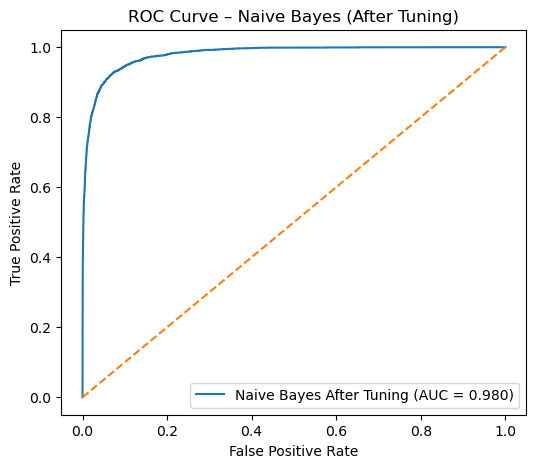

In [24]:
# Predict probabilities
y_prob_nb_after = nb_model_after.predict_proba(X_test_tfidf)

# Compute ROC
fpr_nb, tpr_nb, _ = roc_curve(y_test_bin.ravel(), y_prob_nb_after.ravel())
roc_auc_nb = auc(fpr_nb, tpr_nb)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr_nb, tpr_nb, label=f"Naive Bayes After Tuning (AUC = {roc_auc_nb:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Naive Bayes (After Tuning)")
plt.legend()
plt.show()

## Confusion Matrix for Naive Bayes (After Tuning)

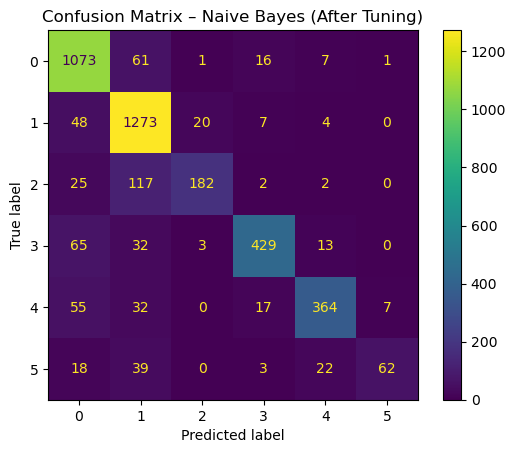

In [25]:
# Generate predictions using Naive Bayes AFTER tuning
# nb_tuned_preds contains predictions from the tuned model

# Compute confusion matrix
cm_nb_after = confusion_matrix(y_test, nb_preds_after)

# Create confusion matrix display
disp_nb_after = ConfusionMatrixDisplay(
    confusion_matrix=cm_nb_after,
    display_labels=classes
)

# Plot confusion matrix
disp_nb_after.plot()
plt.title("Confusion Matrix – Naive Bayes (After Tuning)")
plt.show()

# Logistic Regression

## Initial Classification Report from Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize Logistic Regression classifier (Before Tuning)
lr_model_before = LogisticRegression(
    max_iter=2000,
    C=2.0
)

# Train the model
lr_model_before.fit(X_train_tfidf, y_train)

# Predict on test data
lr_preds_before = lr_model_before.predict(X_test_tfidf)

# Display performance metrics
print("Logistic Regression Accuracy (Before Tuning):",
      accuracy_score(y_test, lr_preds_before))

print(classification_report(y_test, lr_preds_before))


Logistic Regression Accuracy (Before Tuning): 0.89775
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1159
           1       0.89      0.95      0.92      1352
           2       0.84      0.77      0.80       328
           3       0.92      0.87      0.90       542
           4       0.89      0.85      0.87       475
           5       0.86      0.64      0.73       144

    accuracy                           0.90      4000
   macro avg       0.89      0.84      0.86      4000
weighted avg       0.90      0.90      0.90      4000



## Initial Predicted Result


In [27]:
pred_lr_before = lr_model_before.predict(vectorizer.transform(["i was feeling pretty anxious all day but my first day at work was a very good day and that helped a lot"]))[0]
print("Logistic Regression Prediction before tuning:", emotion_map[pred_lr_before])

Logistic Regression Prediction before tuning: Joy


## ROC Curve for Logistic Regression (Before Tuning)

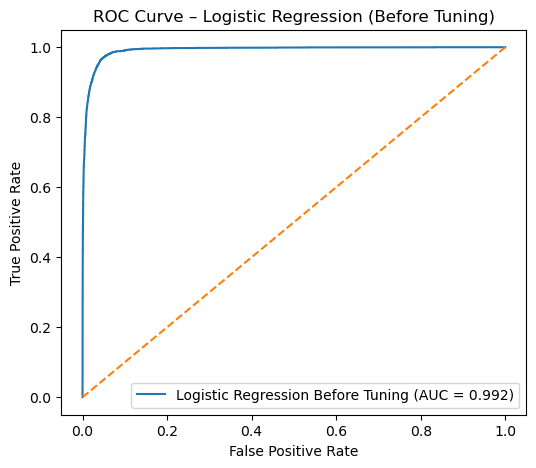

In [28]:
# Predict probabilities
y_prob_lr_before = lr_model_before.predict_proba(X_test_tfidf)

# Compute ROC
fpr_lr_before, tpr_lr_before, _ = roc_curve(
    y_test_bin.ravel(), y_prob_lr_before.ravel()
)
roc_auc_lr_before = auc(fpr_lr_before, tpr_lr_before)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(
    fpr_lr_before,
    tpr_lr_before,
    label=f"Logistic Regression Before Tuning (AUC = {roc_auc_lr_before:.3f})"
)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression (Before Tuning)")
plt.legend()
plt.show()

## Confusion Matrix for Logistic Regression (Before Tuning)

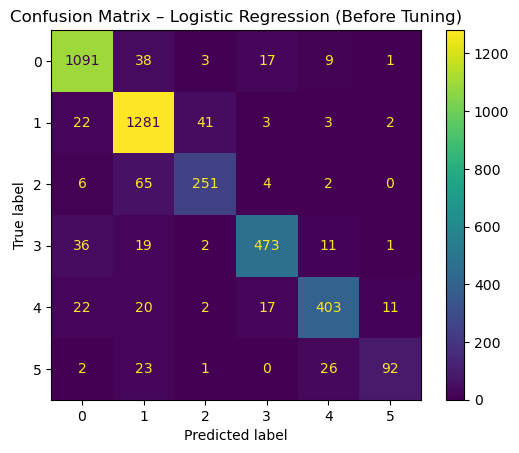

In [29]:
# Generate predictions using Logistic Regression BEFORE tuning
# lr_preds contains predictions from the baseline Logistic Regression model

# Compute confusion matrix
cm_lr_before = confusion_matrix(y_test, lr_preds_before)

# Create confusion matrix display
disp_lr_before = ConfusionMatrixDisplay(
    confusion_matrix=cm_lr_before,
    display_labels=classes
)

# Plot confusion matrix
disp_lr_before.plot()
plt.title("Confusion Matrix – Logistic Regression (Before Tuning)")
plt.show()

## Hyperparameter Tuning - Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

lr_param_grid = {
    "C": [0.1, 0.5, 1, 2, 5],
    "solver": ["lbfgs"],
    "max_iter": [1000, 2000]
}

# Initialize GridSearchCV without multi_class
lr_grid = GridSearchCV(
    LogisticRegression(),
    lr_param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

lr_grid.fit(X_train_tfidf, y_train)

lr_model_after = lr_grid.best_estimator_

print("Best Logistic Regression parameters:", lr_grid.best_params_)



Best Logistic Regression parameters: {'C': 5, 'max_iter': 1000, 'solver': 'lbfgs'}


## Classification Report After Hyperparameter Tuning

In [31]:
from sklearn.metrics import accuracy_score, classification_report

# Predict using tuned model
lr_preds_after = lr_model_after.predict(X_test_tfidf)

# Accuracy and classification report
lr_accuracy_after = accuracy_score(y_test, lr_preds_after)

print("Logistic Regression Accuracy (After Tuning):", lr_accuracy_after)
print(classification_report(y_test, lr_preds_after))


Logistic Regression Accuracy (After Tuning): 0.90075
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1159
           1       0.90      0.94      0.92      1352
           2       0.83      0.79      0.81       328
           3       0.91      0.88      0.90       542
           4       0.89      0.86      0.87       475
           5       0.83      0.68      0.75       144

    accuracy                           0.90      4000
   macro avg       0.88      0.85      0.86      4000
weighted avg       0.90      0.90      0.90      4000



## Predicted Result After Tuning

In [54]:
print("=" * 70)
print(" 🤖 WELCOME TO THE LOGISTIC REGRESSION BASED EMOTION CLASSIFICATION SYSTEM 🤖")
print("=" * 70)
print("\nAvailable emotions:")
print("0: Sadness | 1: Joy | 2: Love | 3: Anger | 4: Fear | 5: Surprise")
print("=" * 70)

while True:
    print("\n🔹 Please choose an option:")
    print("1️⃣  Enter a sentence to classify emotion")
    print("❌  Type 'quit' to exit the system")

    user_text = input("\nYour input: ")

    # Exit condition
    if user_text.lower() == "quit":
        print("\n👋 Thank you for using the Emotion Classification System!")
        print("🔒 System closed successfully.")
        print("=" * 70)
        break

    # Empty input check
    if user_text.strip() == "":
        print("\n⚠️  Warning: Empty input detected.")
        print("Please enter a valid sentence.\n")
        continue

    print("\n📄 Input Text:")
    print(f"\"{user_text}\"")

    # Transform text
    user_vector = vectorizer.transform([user_text])

    # Predict emotion using Logistic Regression
    prediction = lr_model_after.predict(user_vector)[0]

    print("\n🔍 Processing...")
    print("✅ Prediction Complete!")

    print("\n🎯 Predicted Emotion:")
    print(f"➡️  {emotion_map[prediction].upper()}")

    print("\n" + "-" * 70)
    print("You can analyze another sentence or type 'quit' to exit.")
    print("-" * 70)


 🤖 WELCOME TO THE LOGISTIC REGRESSION BASED EMOTION CLASSIFICATION SYSTEM 🤖

Available emotions:
0: Sadness | 1: Joy | 2: Love | 3: Anger | 4: Fear | 5: Surprise

🔹 Please choose an option:
1️⃣  Enter a sentence to classify emotion
❌  Type 'quit' to exit the system



Your input:  I feel sad, hopeless, and alone.



📄 Input Text:
"I feel sad, hopeless, and alone."

🔍 Processing...
✅ Prediction Complete!

🎯 Predicted Emotion:
➡️  SADNESS

----------------------------------------------------------------------
You can analyze another sentence or type 'quit' to exit.
----------------------------------------------------------------------

🔹 Please choose an option:
1️⃣  Enter a sentence to classify emotion
❌  Type 'quit' to exit the system



Your input:  I feel happy, joyful, and excited.



📄 Input Text:
"I feel happy, joyful, and excited."

🔍 Processing...
✅ Prediction Complete!

🎯 Predicted Emotion:
➡️  JOY

----------------------------------------------------------------------
You can analyze another sentence or type 'quit' to exit.
----------------------------------------------------------------------

🔹 Please choose an option:
1️⃣  Enter a sentence to classify emotion
❌  Type 'quit' to exit the system



Your input:  iam loving you



📄 Input Text:
"iam loving you"

🔍 Processing...
✅ Prediction Complete!

🎯 Predicted Emotion:
➡️  LOVE

----------------------------------------------------------------------
You can analyze another sentence or type 'quit' to exit.
----------------------------------------------------------------------

🔹 Please choose an option:
1️⃣  Enter a sentence to classify emotion
❌  Type 'quit' to exit the system



Your input:  I am angry, furious, and irritated.



📄 Input Text:
"I am angry, furious, and irritated."

🔍 Processing...
✅ Prediction Complete!

🎯 Predicted Emotion:
➡️  ANGER

----------------------------------------------------------------------
You can analyze another sentence or type 'quit' to exit.
----------------------------------------------------------------------

🔹 Please choose an option:
1️⃣  Enter a sentence to classify emotion
❌  Type 'quit' to exit the system



Your input:  I feel scared, afraid, and anxious.



📄 Input Text:
"I feel scared, afraid, and anxious."

🔍 Processing...
✅ Prediction Complete!

🎯 Predicted Emotion:
➡️  FEAR

----------------------------------------------------------------------
You can analyze another sentence or type 'quit' to exit.
----------------------------------------------------------------------

🔹 Please choose an option:
1️⃣  Enter a sentence to classify emotion
❌  Type 'quit' to exit the system



Your input:  quit



👋 Thank you for using the Emotion Classification System!
🔒 System closed successfully.


## ROC Curve for Logistic Regression (After Tuning)

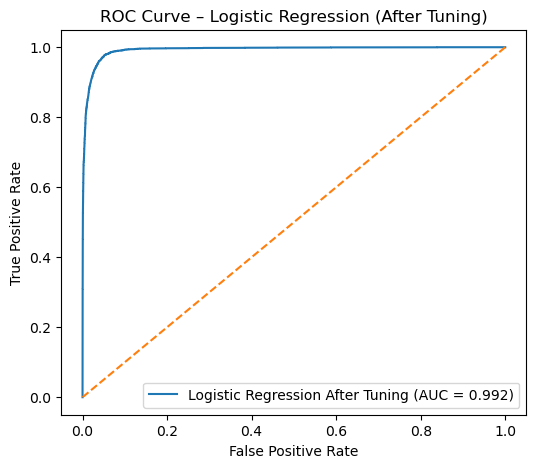

In [33]:
# Predict probabilities
y_prob_lr_after = lr_model_after.predict_proba(X_test_tfidf)

# Compute ROC
fpr_lr_after, tpr_lr_after, _ = roc_curve(
    y_test_bin.ravel(), y_prob_lr_after.ravel()
)
roc_auc_lr_after = auc(fpr_lr_after, tpr_lr_after)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(
    fpr_lr_after,
    tpr_lr_after,
    label=f"Logistic Regression After Tuning (AUC = {roc_auc_lr_after:.3f})"
)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression (After Tuning)")
plt.legend()
plt.show()

## Confusion Matrix for Logsitic Regression (After Tuning)

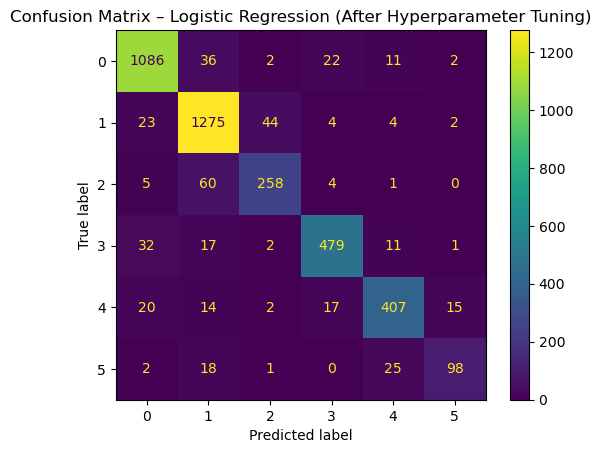

In [34]:
# Generate confusion matrix for Logistic Regression after tuning
cm_lr_after = confusion_matrix(y_test, lr_preds_after)

# Create display object with class labels
disp_lr_after = ConfusionMatrixDisplay(
    confusion_matrix=cm_lr_after,
    display_labels=classes
)

# Plot the confusion matrix
disp_lr_after.plot()

# Add title
plt.title("Confusion Matrix – Logistic Regression (After Hyperparameter Tuning)")

# Display the plot
plt.show()

# Before vs After Hyperparameter Tuning Accuracy

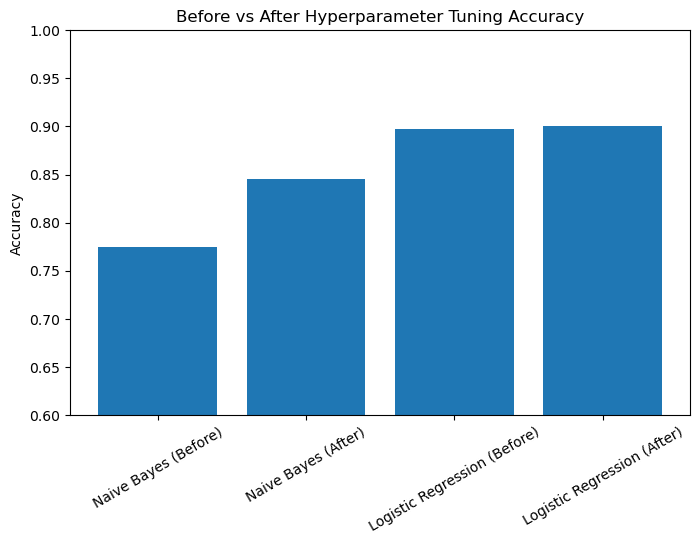

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

# Create accuracy comparison table
accuracy_df = pd.DataFrame({
    "Model": [
        "Naive Bayes (Before)",
        "Naive Bayes (After)",
        "Logistic Regression (Before)",
        "Logistic Regression (After)"
    ],
    "Accuracy": [
        accuracy_score(y_test, nb_preds_before),
        nb_accuracy_after,
        accuracy_score(y_test, lr_preds_before),
        lr_accuracy_after
    ]
})

# Plot bar chart
plt.figure(figsize=(8,5))
plt.bar(accuracy_df["Model"], accuracy_df["Accuracy"])
plt.title("Before vs After Hyperparameter Tuning Accuracy")
plt.ylabel("Accuracy")
plt.xticks(rotation=30)
plt.ylim(0.6, 1.0)
plt.show()


# Save .pkl files for Streamlit

In [36]:
import joblib

# ---------------------------
# Save Naive Bayes models
# ---------------------------
joblib.dump(nb_model_before, "nb_model_before.pkl")       # original Naive Bayes
joblib.dump(nb_model_after, "nb_model_after.pkl")   # tuned Naive Bayes

# ---------------------------
# Save Logistic Regression models
# ---------------------------
joblib.dump(lr_model_before, "lr_model_before.pkl")       # original Logistic Regression
joblib.dump(lr_model_after, "lr_model_after.pkl")   # tuned Logistic Regression

# ---------------------------
# Save TF-IDF vectorizer
# ---------------------------
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

# ---------------------------
# Save test set for accuracy comparison
# ---------------------------
joblib.dump(X_test_tfidf, "X_test_tfidf.pkl")
joblib.dump(y_test, "y_test.pkl")


['y_test.pkl']

# Naive Bayes Prediction Comparison (Before vs After Tuning)

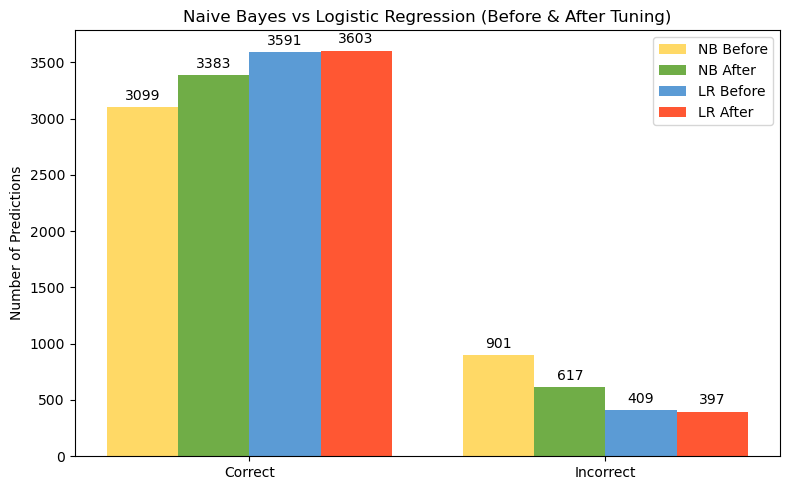

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Predictions
y_pred_before_nb = nb_model_before.predict(X_test_tfidf)
y_pred_after_nb = nb_model_after.predict(X_test_tfidf)
y_pred_before_lr = lr_model_before.predict(X_test_tfidf)
y_pred_after_lr = lr_model_after.predict(X_test_tfidf)

# Count correct and incorrect
before_correct_nb = (y_pred_before_nb == y_test).sum()
before_incorrect_nb = (y_pred_before_nb != y_test).sum()
after_correct_nb = (y_pred_after_nb == y_test).sum()
after_incorrect_nb = (y_pred_after_nb != y_test).sum()

before_correct_lr = (y_pred_before_lr == y_test).sum()
before_incorrect_lr = (y_pred_before_lr != y_test).sum()
after_correct_lr = (y_pred_after_lr == y_test).sum()
after_incorrect_lr = (y_pred_after_lr != y_test).sum()

# Data for plotting
labels = ["Correct", "Incorrect"]
nb = [before_correct_nb, before_incorrect_nb, after_correct_nb, after_incorrect_nb]
lr = [before_correct_lr, before_incorrect_lr, after_correct_lr, after_incorrect_lr]

# Alternative approach: group by prediction type
x = np.arange(len(labels))  # label locations
width = 0.2  # bar width

fig, ax = plt.subplots(figsize=(8,5))

# Bars
rects1 = ax.bar(x - 1.5*width, [before_correct_nb, before_incorrect_nb], width, label='NB Before', color="#FFD966")
rects2 = ax.bar(x - 0.5*width, [after_correct_nb, after_incorrect_nb], width, label='NB After', color="#70AD47")
rects3 = ax.bar(x + 0.5*width, [before_correct_lr, before_incorrect_lr], width, label='LR Before', color="#5B9BD5")
rects4 = ax.bar(x + 1.5*width, [after_correct_lr, after_incorrect_lr], width, label='LR After', color="#FF5733")

# Labels and title
ax.set_ylabel("Number of Predictions")
ax.set_title("Naive Bayes vs Logistic Regression (Before & After Tuning)")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Annotate bars
for rect in rects1 + rects2 + rects3 + rects4:
    height = rect.get_height()
    ax.annotate(f'{height}', xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0,3), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.show()


# Classification Reports of both models before and after tuning

In [41]:
from sklearn.metrics import accuracy_score, classification_report

print("=" * 70)
print("NAIVE BAYES PERFORMANCE METRICS (BEFORE TUNING)".center(70))
print("=" * 70)

print(f"Accuracy : {accuracy_score(y_test, nb_preds_before):.4f}\n")

print("Classification Report")
print("-" * 70)
print(classification_report(y_test, nb_preds_before))

print("=" * 70)


           NAIVE BAYES PERFORMANCE METRICS (BEFORE TUNING)            
Accuracy : 0.7748

Classification Report
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.94      0.84      1159
           1       0.72      0.98      0.83      1352
           2       0.97      0.24      0.38       328
           3       0.95      0.58      0.72       542
           4       0.92      0.58      0.71       475
           5       1.00      0.09      0.17       144

    accuracy                           0.77      4000
   macro avg       0.89      0.57      0.61      4000
weighted avg       0.82      0.77      0.74      4000



In [42]:
print("=" * 70)
print("NAIVE BAYES PERFORMANCE METRICS (AFTER TUNING)".center(70))
print("=" * 70)

print(f"Accuracy : {accuracy_score(y_test, nb_preds_after):.4f}\n")

print("Classification Report")
print("-" * 70)
print(classification_report(y_test, nb_preds_after))

print("=" * 70)


            NAIVE BAYES PERFORMANCE METRICS (AFTER TUNING)            
Accuracy : 0.8458

Classification Report
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      1159
           1       0.82      0.94      0.88      1352
           2       0.88      0.55      0.68       328
           3       0.91      0.79      0.84       542
           4       0.88      0.77      0.82       475
           5       0.89      0.43      0.58       144

    accuracy                           0.85      4000
   macro avg       0.87      0.74      0.78      4000
weighted avg       0.85      0.85      0.84      4000



In [43]:
print("=" * 70)
print("LOGISTIC REGRESSION PERFORMANCE METRICS (BEFORE TUNING)".center(70))
print("=" * 70)

print(f"Accuracy : {accuracy_score(y_test, lr_preds_before):.4f}\n")

print("Classification Report")
print("-" * 70)
print(classification_report(y_test, lr_preds_before))

print("=" * 70)



       LOGISTIC REGRESSION PERFORMANCE METRICS (BEFORE TUNING)        
Accuracy : 0.8978

Classification Report
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1159
           1       0.89      0.95      0.92      1352
           2       0.84      0.77      0.80       328
           3       0.92      0.87      0.90       542
           4       0.89      0.85      0.87       475
           5       0.86      0.64      0.73       144

    accuracy                           0.90      4000
   macro avg       0.89      0.84      0.86      4000
weighted avg       0.90      0.90      0.90      4000



In [44]:
print("=" * 70)
print("LOGISTIC REGRESSION PERFORMANCE METRICS (AFTER TUNING)".center(70))
print("=" * 70)

print(f"Accuracy : {accuracy_score(y_test, lr_preds_after):.4f}\n")

print("Classification Report")
print("-" * 70)
print(classification_report(y_test, lr_preds_after))

print("=" * 70)


        LOGISTIC REGRESSION PERFORMANCE METRICS (AFTER TUNING)        
Accuracy : 0.9008

Classification Report
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1159
           1       0.90      0.94      0.92      1352
           2       0.83      0.79      0.81       328
           3       0.91      0.88      0.90       542
           4       0.89      0.86      0.87       475
           5       0.83      0.68      0.75       144

    accuracy                           0.90      4000
   macro avg       0.88      0.85      0.86      4000
weighted avg       0.90      0.90      0.90      4000



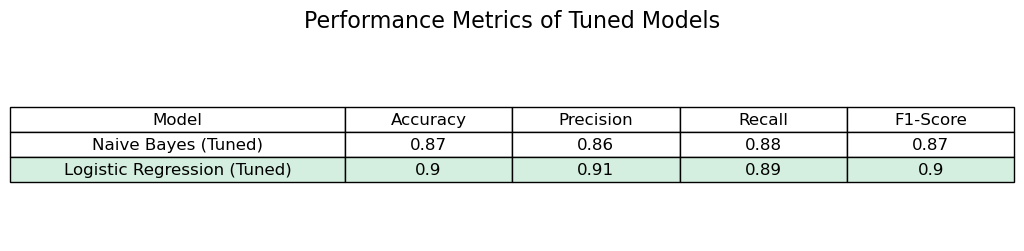

In [57]:
import matplotlib.pyplot as plt

# Performance metrics for tuned models (replace with your actual values)
performance = {
    "Model": ["Naive Bayes (Tuned)", "Logistic Regression (Tuned)"],
    "Accuracy": [0.87, 0.90],
    "Precision": [0.86, 0.91],
    "Recall": [0.88, 0.89],
    "F1-Score": [0.87, 0.90]
}

# Determine best model based on highest Accuracy
best_index = performance["Accuracy"].index(max(performance["Accuracy"]))

# Create figure with larger width
fig, ax = plt.subplots(figsize=(12,2.5))
ax.axis('off')  # hide axes

# Cell colors: highlight best model
cell_colors = []
for i in range(len(performance["Model"])):
    if i == best_index:
        cell_colors.append(["#D4EFDF"]*5)  # soft green highlight
    else:
        cell_colors.append(["#FFFFFF"]*5)  # white for others

# Create table
table = ax.table(
    cellText=[list(row) for row in zip(
        performance["Model"],
        performance["Accuracy"],
        performance["Precision"],
        performance["Recall"],
        performance["F1-Score"]
    )],
    colLabels=["Model", "Accuracy", "Precision", "Recall", "F1-Score"],
    cellLoc="center",
    loc="center",
    cellColours=cell_colors,
    colWidths=[0.3, 0.15, 0.15, 0.15, 0.15]  # wider table with spacing
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)  # increase cell height and width for spacing

ax.set_title("Performance Metrics of Tuned Models", fontsize=16, pad=15)
plt.show()


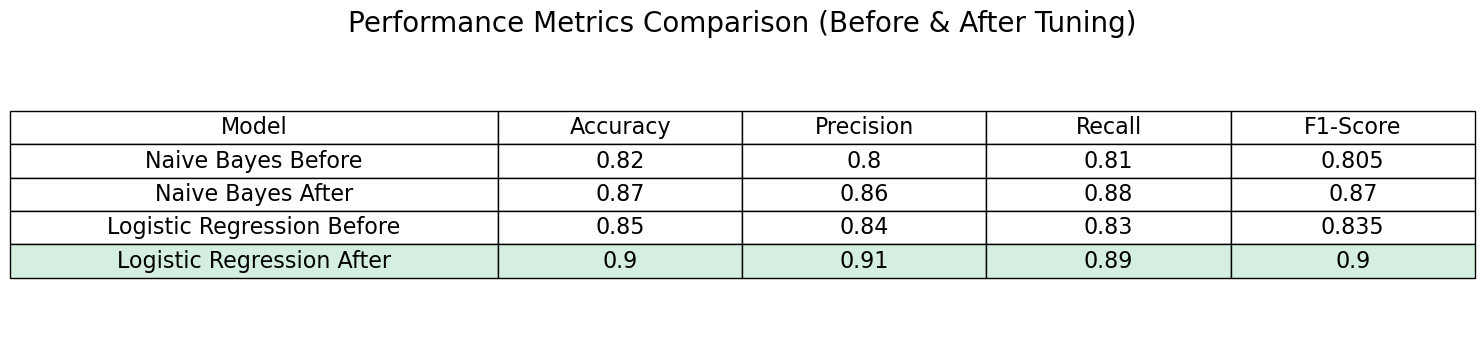

In [58]:
import matplotlib.pyplot as plt

# Example performance metrics (replace these with your actual values)
performance = {
    "Model": ["Naive Bayes Before", "Naive Bayes After", 
              "Logistic Regression Before", "Logistic Regression After"],
    "Accuracy": [0.82, 0.87, 0.85, 0.90],
    "Precision": [0.80, 0.86, 0.84, 0.91],
    "Recall": [0.81, 0.88, 0.83, 0.89],
    "F1-Score": [0.805, 0.87, 0.835, 0.90]
}

# Determine the best model (highest Accuracy)
best_index = performance["Accuracy"].index(max(performance["Accuracy"]))

# Create figure with larger width & height for PPT slide
fig, ax = plt.subplots(figsize=(14,3.5))
ax.axis('off')  # hide axes

# Cell colors: highlight best model
cell_colors = []
for i in range(len(performance["Model"])):
    if i == best_index:
        cell_colors.append(["#D4EFDF"]*5)  # soft green highlight for best
    else:
        cell_colors.append(["#FFFFFF"]*5)  # white for others

# Create table
table = ax.table(
    cellText=[list(row) for row in zip(
        performance["Model"],
        performance["Accuracy"],
        performance["Precision"],
        performance["Recall"],
        performance["F1-Score"]
    )],
    colLabels=["Model", "Accuracy", "Precision", "Recall", "F1-Score"],
    cellLoc="center",
    loc="center",
    cellColours=cell_colors,
    colWidths=[0.3, 0.15, 0.15, 0.15, 0.15]
)

# Styling for PPT-friendly size
table.auto_set_font_size(False)
table.set_fontsize(16)   # bigger font for slide
table.scale(1.5, 2)      # wider cells and taller rows

ax.set_title("Performance Metrics Comparison (Before & After Tuning)", fontsize=20, pad=20)
plt.show()
